# Real-time Load Prediction and Resource Management - Model Building and Evaluation
 
This notebook focuses on building predictive models using processed time series data, evaluating their performance, and analyzing the prediction results.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Time series model related libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 1. Data Loading and Exploratory Analysis

In [2]:
# Load user time series data
data_path = '../processed_data/c7_user_DrrEIEW_timeseries.csv'
df = pd.read_csv(data_path)

# View basic information about the data
print(f"Data shape: {df.shape}")
display(df.head())
display(df.info())
display(df.describe())

数据形状: (723, 8)


,user,hour,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
0,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 00:00:00,0.010010,0.011169,0.006195,2.872467e-03,0.059387,1.002502e-02
1,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 01:00:00,0.006386,0.001303,0.021851,1.248169e-02,0.084839,2.093506e-02
2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 02:00:00,0.006699,0.001303,0.013733,1.423645e-02,0.049194,1.449585e-02
3,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 03:00:00,0.003929,0.001303,0.005302,4.875183e-03,0.039307,9.979248e-03
4,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 04:00:00,0.003960,0.001303,0.000048,9.536743e-07,0.000250,9.536743e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user                     723 non-null    object 
 1   hour                     723 non-null    object 
 2   resource_request_cpu     723 non-null    float64
 3   resource_request_memory  723 non-null    float64
 4   average_usage_cpu        723 non-null    float64
 5   average_usage_memory     723 non-null    float64
 6   maximum_usage_cpu        723 non-null    float64
 7   maximum_usage_memory     723 non-null    float64
dtypes: float64(6), object(2)
memory usage: 45.3+ KB


None

,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,0.012226,0.001401,0.006904,0.006644,0.023063,0.007615
std,0.004498,0.001394,0.011707,0.005012,0.040485,0.005698
min,0.001987,0.001303,0.000000,0.000000,0.000000,0.000000
25%,0.009842,0.001303,0.000611,0.005096,0.001392,0.005295
50%,0.011154,0.001303,0.000611,0.005287,0.001392,0.005295
75%,0.011154,0.001303,0.006096,0.010101,0.035706,0.010162
max,0.022858,0.028748,0.054626,0.021515,0.240723,0.022522


In [3]:
# Convert the time column to the correct date and time format
df['hour'] = pd.to_datetime(df['hour'])

# Set hour as the index
df.set_index('hour', inplace=True)

# Check the continuity of the time series
time_diff = df.index.to_series().diff().value_counts()
print("Time interval statistics:")
print(time_diff)

# Check if there are missing time points
min_time = df.index.min()
max_time = df.index.max()
full_range = pd.date_range(start=min_time, end=max_time, freq='h')
missing_times = full_range.difference(df.index)
print(f"\nNumber of missing time points: {len(missing_times)}")
if len(missing_times) > 0:
    print(f"Examples of missing time points: {missing_times[:5]}")

时间间隔统计:
hour
0 days 01:00:00    709
0 days 02:00:00      7
0 days 03:00:00      4
0 days 04:00:00      1
0 days 05:00:00      1
Name: count, dtype: int64

缺失的时间点数量: 22
示例缺失时间点: DatetimeIndex(['1970-01-05 04:00:00', '1970-01-05 08:00:00',
               '1970-01-05 10:00:00', '1970-01-11 06:00:00',
               '1970-01-11 07:00:00'],
              dtype='datetime64[ns]', freq=None)


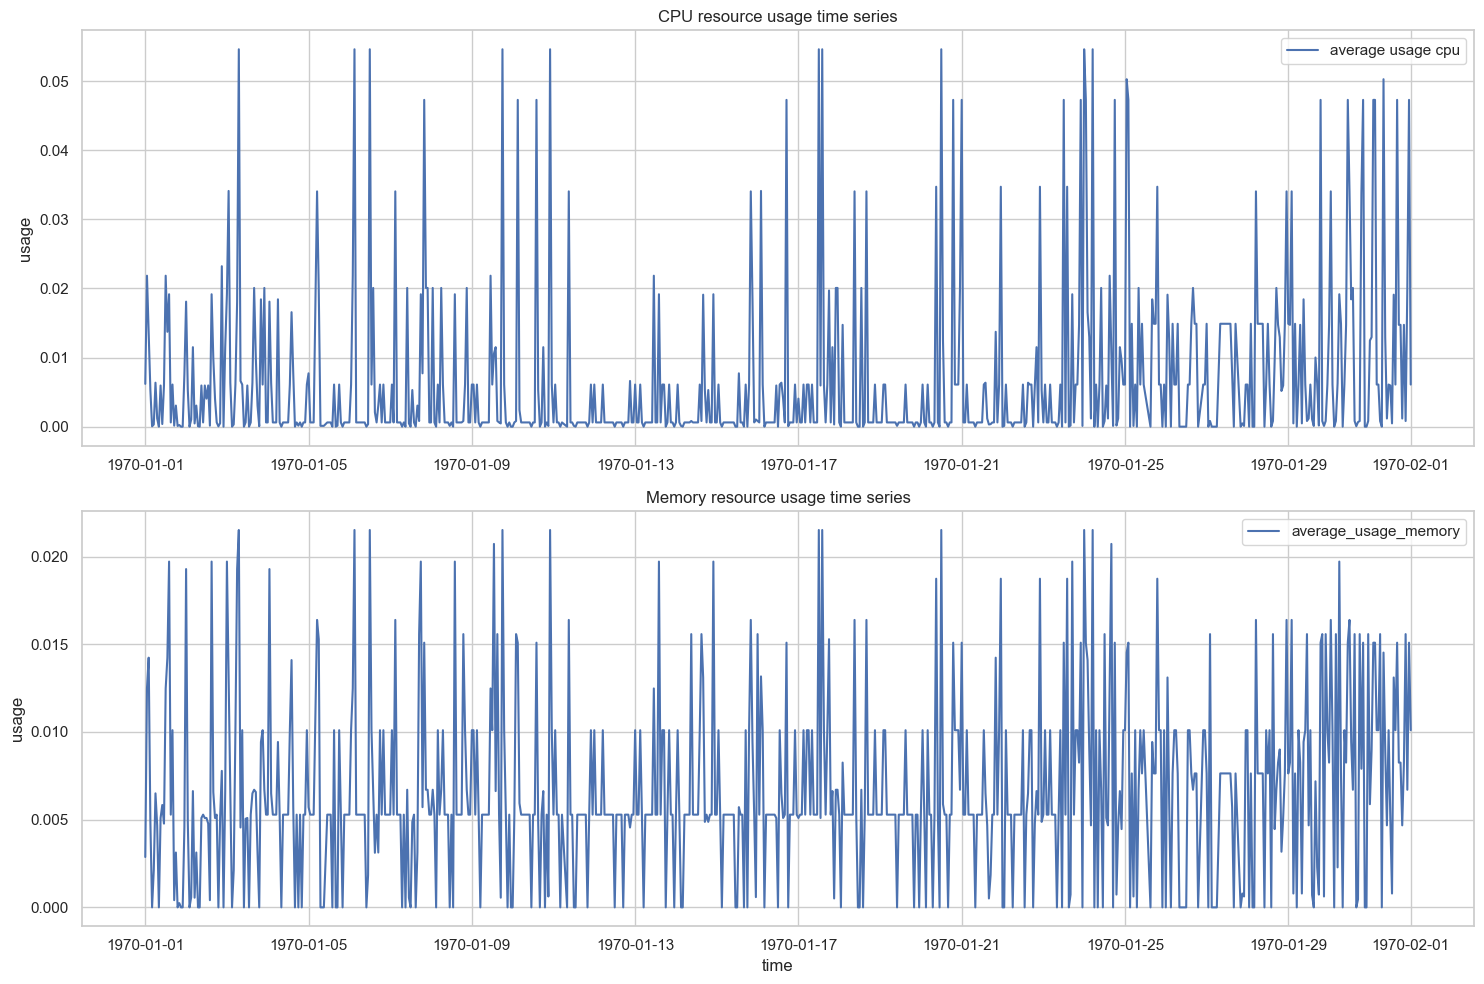

In [ ]:
# Visualizing time series
plt.figure(figsize=(15, 10))

# CPU usage plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['average_usage_cpu'], label='average usage cpu')
#plt.plot(df.index, df['resource_request_cpu'], label='resource request cpu', alpha=0.7)
#plt.plot(df.index, df['maximum_usage_cpu'], label='maximum_usage_cpu', alpha=0.5)
plt.title('CPU Resource Usage Time Series')
plt.ylabel('Usage')
plt.legend()
plt.grid(True)

# Memory usage plot
plt.subplot(2, 1, 2)
plt.plot(df.index, df['average_usage_memory'], label='average_usage_memory')
#plt.plot(df.index, df['resource_request_memory'], label='resource_request_memory', alpha=0.7)
#plt.plot(df.index, df['maximum_usage_memory'], label='maximum_usage_memory', alpha=0.5)
plt.title('Memory Resource Usage Time Series')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 2. Data Preprocessing

缺失值统计:
user                       0
resource_request_cpu       0
resource_request_memory    0
average_usage_cpu          0
average_usage_memory       0
maximum_usage_cpu          0
maximum_usage_memory       0
dtype: int64
重采样后的数据形状: (745, 7)


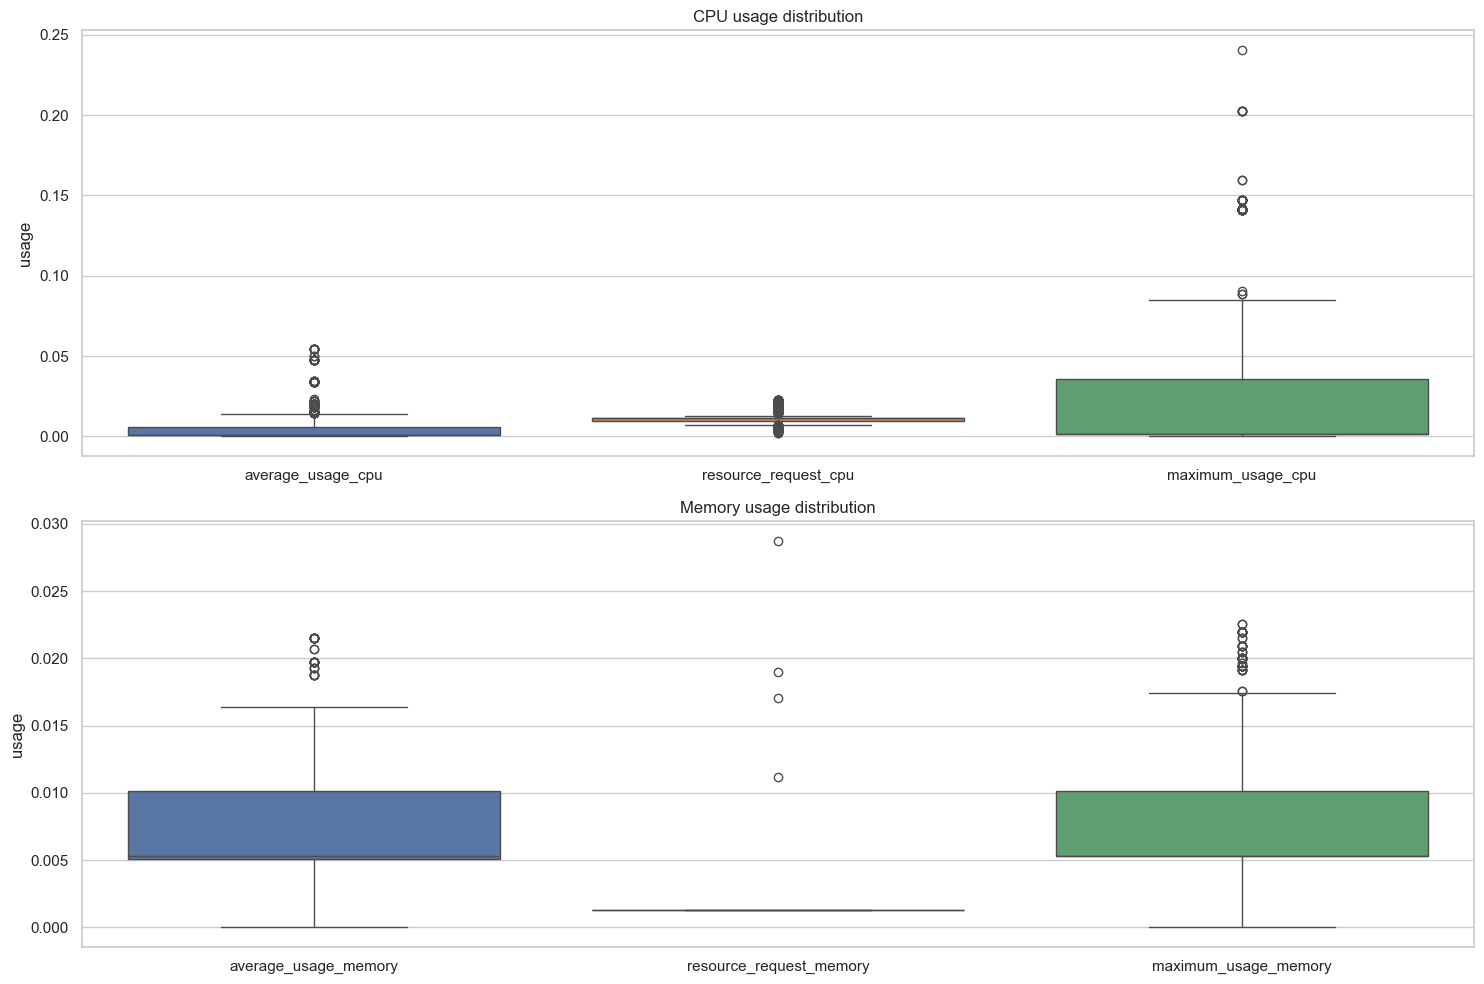

In [ ]:
# Handle missing values (if any)
print("Missing value statistics:")
print(df.isnull().sum())

# If there are missing time points, they can be filled using resampling
if len(missing_times) > 0:
    # Resample to hourly level and fill missing values with forward fill
    df = df.resample('h').ffill()
    print("Data shape after resampling:", df.shape)

# Check for outliers
plt.figure(figsize=(15, 10))

# CPU usage boxplot
plt.subplot(2, 1, 1)
sns.boxplot(data=df[['average_usage_cpu', 'resource_request_cpu', 'maximum_usage_cpu']])
plt.title('CPU usage distribution')
plt.ylabel('usage')

# Memory usage boxplot
plt.subplot(2, 1, 2)
sns.boxplot(data=df[['average_usage_memory', 'resource_request_memory', 'maximum_usage_memory']])
plt.title('Memory usage distribution')
plt.ylabel('usage')

plt.tight_layout()
plt.show()

In [ ]:
# Create time series features
df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features
for lag in [1, 3, 6, 12, 24]:  # 1 hour, 3 hours, 6 hours, 12 hours, 24 hours lag
    df[f'cpu_lag_{lag}'] = df['average_usage_cpu'].shift(lag)
    df[f'memory_lag_{lag}'] = df['average_usage_memory'].shift(lag)

# Add rolling window features
for window in [3, 6, 12, 24]:
    df[f'cpu_rolling_mean_{window}'] = df['average_usage_cpu'].rolling(window=window).mean()
    df[f'memory_rolling_mean_{window}'] = df['average_usage_memory'].rolling(window=window).mean()
    
    df[f'cpu_rolling_std_{window}'] = df['average_usage_cpu'].rolling(window=window).std()
    df[f'memory_rolling_std_{window}'] = df['average_usage_memory'].rolling(window=window).std()

# Remove the first 24 rows because they have NaN values (due to lag and rolling window)
df = df.iloc[24:].copy()

# View the processed data
print(f"Shape of processed data: {df.shape}")
display(df.head())

处理后的数据形状: (721, 36)


,user,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour_of_day,day_of_week,is_weekend,cpu_lag_1,memory_lag_1,cpu_lag_3,memory_lag_3,cpu_lag_6,memory_lag_6,cpu_lag_12,memory_lag_12,cpu_lag_24,memory_lag_24,cpu_rolling_mean_3,memory_rolling_mean_3,cpu_rolling_std_3,memory_rolling_std_3,cpu_rolling_mean_6,memory_rolling_mean_6,cpu_rolling_std_6,memory_rolling_std_6,cpu_rolling_mean_12,memory_rolling_mean_12,cpu_rolling_std_12,memory_rolling_std_12,cpu_rolling_mean_24,memory_rolling_mean_24,cpu_rolling_std_24,memory_rolling_std_24
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-02 00:00:00,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.007271,0.001303,0.018097,1.928711e-02,0.035706,2.044678e-02,0,4,0,0.007591,4.577637e-03,0.000000,9.536743e-07,0.003052,3.128052e-03,0.021851,0.012482,0.006195,2.872467e-03,0.008563,0.007955,0.009087,0.010077,0.004338,0.004018,0.007379,0.007696,0.005736,0.006416,0.007343,0.007570,0.006324,0.006253,0.007555,0.006169
1970-01-02 01:00:00,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.004974,0.001303,0.005302,4.875183e-03,0.039307,9.979248e-03,1,4,0,0.018097,1.928711e-02,0.000000,9.536743e-07,0.000107,9.536743e-07,0.013733,0.014236,0.021851,1.248169e-02,0.010330,0.009580,0.006823,0.008408,0.005204,0.004831,0.007082,0.007440,0.005033,0.005635,0.006898,0.007162,0.005635,0.005936,0.006793,0.006029
1970-01-02 02:00:00,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.008438,0.001303,0.000000,9.536743e-07,0.000000,9.536743e-07,2,4,0,0.005302,4.875183e-03,0.007591,4.577637e-03,0.000236,2.412796e-04,0.019165,0.019714,0.013733,1.423645e-02,0.007800,0.008054,0.009303,0.010028,0.005165,0.004790,0.007116,0.007470,0.003436,0.003993,0.005381,0.005764,0.005063,0.005343,0.006659,0.005875
1970-01-02 03:00:00,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.005295,0.001303,0.001036,5.846024e-04,0.002769,7.963181e-04,3,4,0,0.000000,9.536743e-07,0.018097,1.928711e-02,0.000000,9.536743e-07,0.000611,0.005287,0.005302,4.875183e-03,0.002113,0.001820,0.002811,0.002662,0.005338,0.004888,0.006977,0.007399,0.003472,0.003601,0.005362,0.005827,0.004885,0.005164,0.006709,0.005955
1970-01-02 04:00:00,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.005630,0.001303,0.011505,6.629944e-03,0.049011,9.963989e-03,4,4,0,0.001036,5.846024e-04,0.005302,4.875183e-03,0.000000,9.536743e-07,0.006096,0.010101,0.000048,9.536743e-07,0.004180,0.002405,0.006365,0.003670,0.007255,0.005993,0.006795,0.007008,0.003922,0.003312,0.005811,0.005555,0.005362,0.005440,0.006757,0.005858


In [7]:
# Prepare the training and testing sets
# Use the last 20% of the data as the testing set
test_size = int(0.2 * len(df))
train_df = df.iloc[:-test_size].copy()
test_df = df.iloc[-test_size:].copy()

print(f"Training set size: {train_df.shape}")
print(f"Testing set size: {test_df.shape}")

训练集大小: (577, 36)
测试集大小: (144, 36)


## 3. Feature Importance Analysis

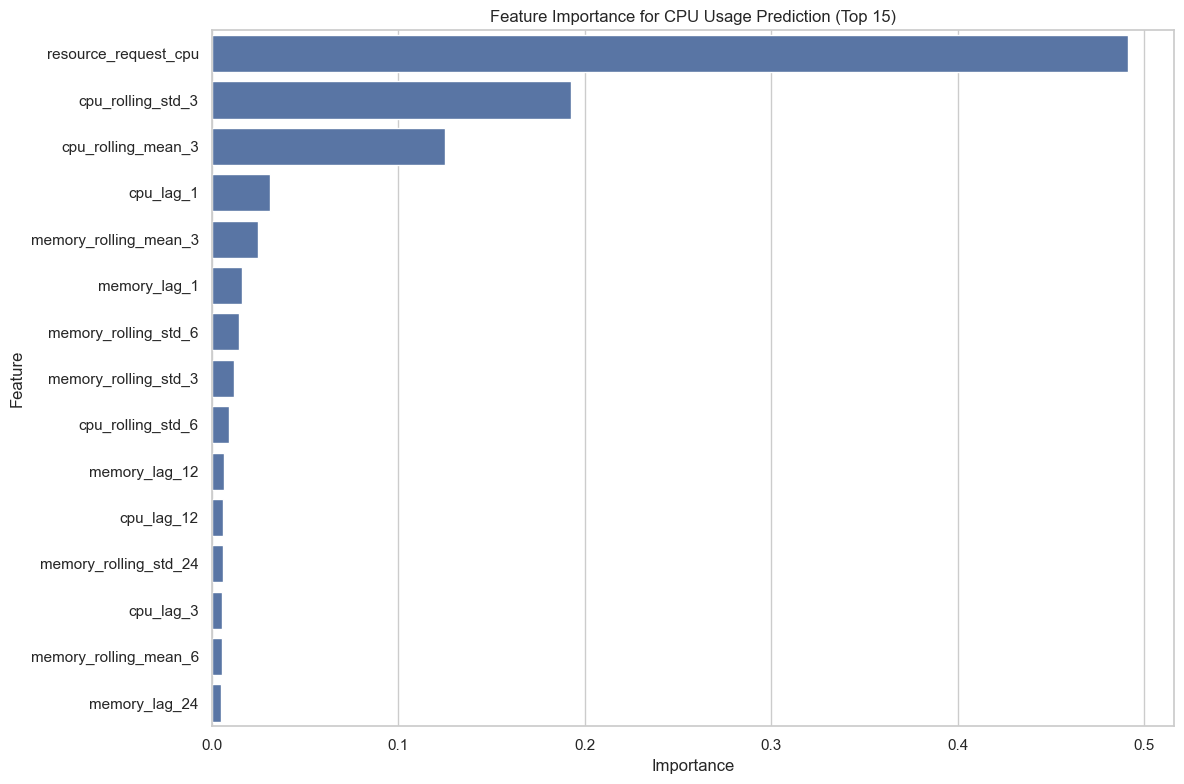

In [ ]:
# Define the feature set
feature_columns = [
    'resource_request_cpu', 'resource_request_memory',
    'hour_of_day', 'day_of_week', 'is_weekend'
]

# Add lag features
for lag in [1, 3, 6, 12, 24]:
    feature_columns.append(f'cpu_lag_{lag}')
    feature_columns.append(f'memory_lag_{lag}')

# Add rolling window features
for window in [3, 6, 12, 24]:
    feature_columns.append(f'cpu_rolling_mean_{window}')
    feature_columns.append(f'memory_rolling_mean_{window}')
    feature_columns.append(f'cpu_rolling_std_{window}')
    feature_columns.append(f'memory_rolling_std_{window}')

# Analyze CPU usage feature importance using random forest
X_train = train_df[feature_columns]
y_train_cpu = train_df['average_usage_cpu']

# Train random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_cpu)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Feature Importance for CPU Usage Prediction (Top 15)')
plt.tight_layout()
plt.show()

## 4. Model Construction and Evaluation
We will try a variety of models and evaluate their performance

In [9]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} evaluation results:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")
    print("-----------------------------------")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

### 4.1 ARIMA Model(baseline)

ARIMA 评估结果:
RMSE: 0.013940
MAE: 0.009311
R²: -0.283923
-----------------------------------


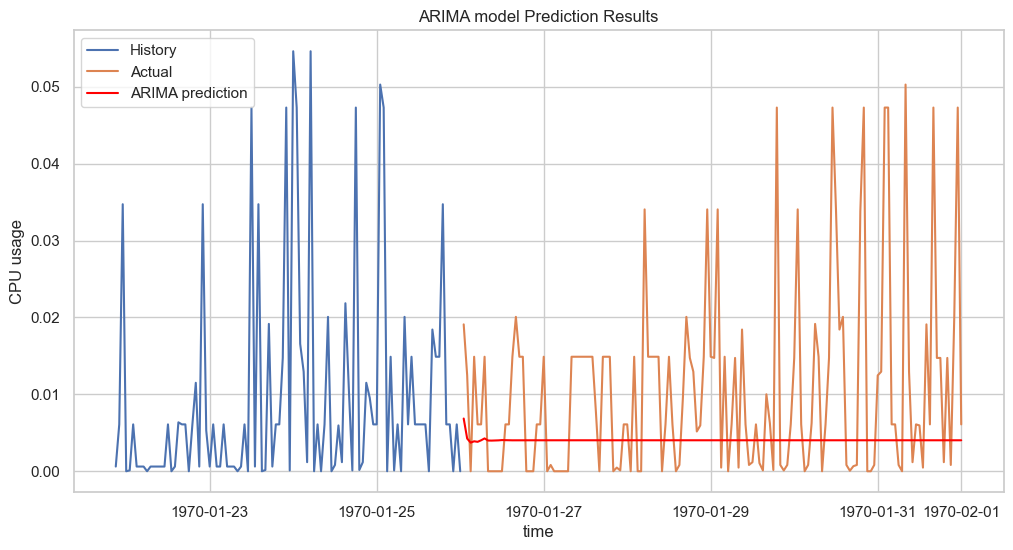

In [ ]:
# Prepare ARIMA training data (using only the time series of the target variable)
y_train_arima = train_df['average_usage_cpu']
y_test_arima = test_df['average_usage_cpu']

# Train ARIMA model
try:
    # Parameters may need to be adjusted (p,d,q)
    arima_model = ARIMA(y_train_arima, order=(5,1,0))
    arima_fit = arima_model.fit()
    
    # Predict
    arima_forecast = arima_fit.forecast(steps=len(test_df))
    
    # Evaluate
    arima_results = evaluate_model(y_test_arima, arima_forecast, "ARIMA")
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index[-100:], train_df['average_usage_cpu'][-100:], label='History')
    plt.plot(test_df.index, y_test_arima, label='Actual')
    plt.plot(test_df.index, arima_forecast, label='ARIMA prediction', color='red')
    plt.title('ARIMA model Prediction Results')
    plt.xlabel('time')
    plt.ylabel('CPU usage')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"ARIMA model training failed: {e}")

### 4.2 Random Forest Model

Random Forest 评估结果:
RMSE: 0.009052
MAE: 0.006643
R²: 0.458637
-----------------------------------


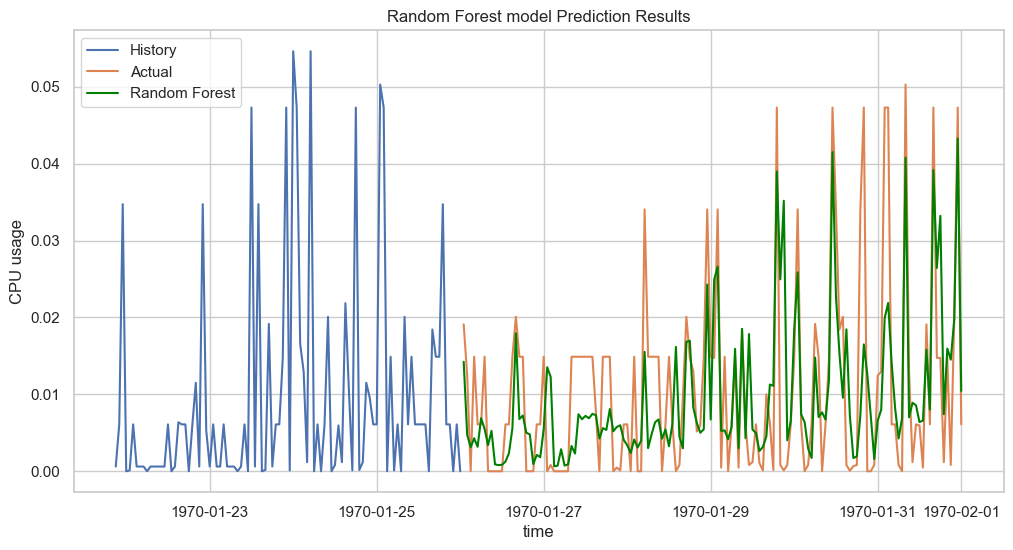

In [ ]:
# Prepare the training data for the random forest
X_test = test_df[feature_columns]
y_test_cpu = test_df['average_usage_cpu']

# Use the trained random forest model for prediction
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_results = evaluate_model(y_test_cpu, rf_predictions, "Random Forest")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index[-100:], train_df['average_usage_cpu'][-100:], label='History')
plt.plot(test_df.index, y_test_cpu, label='Actual')
plt.plot(test_df.index, rf_predictions, label='Random Forest', color='green')
plt.title('Random Forest Model Prediction Results')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

### 4.3 XGBoost Model

XGBoost 评估结果:
RMSE: 0.008468
MAE: 0.005976
R²: 0.526218
-----------------------------------


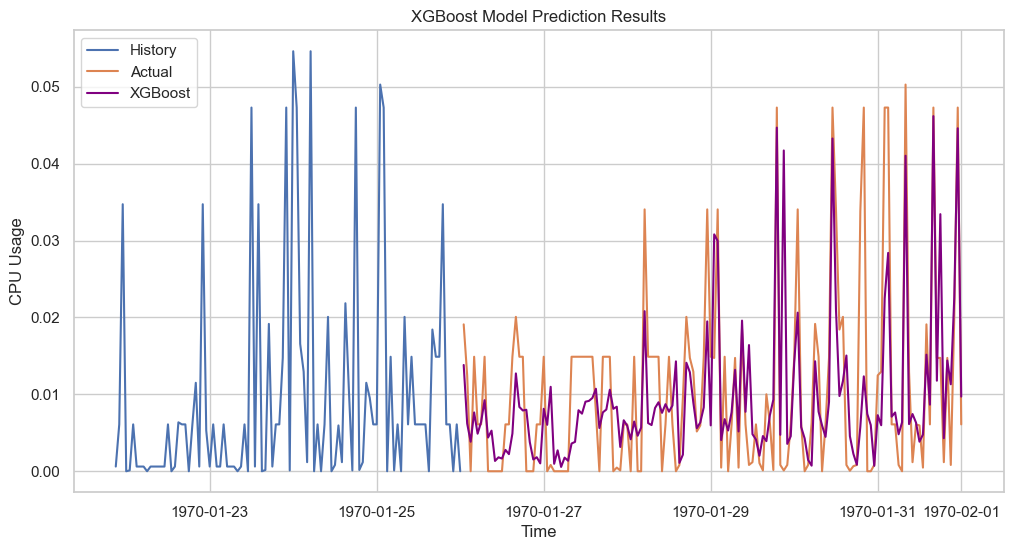

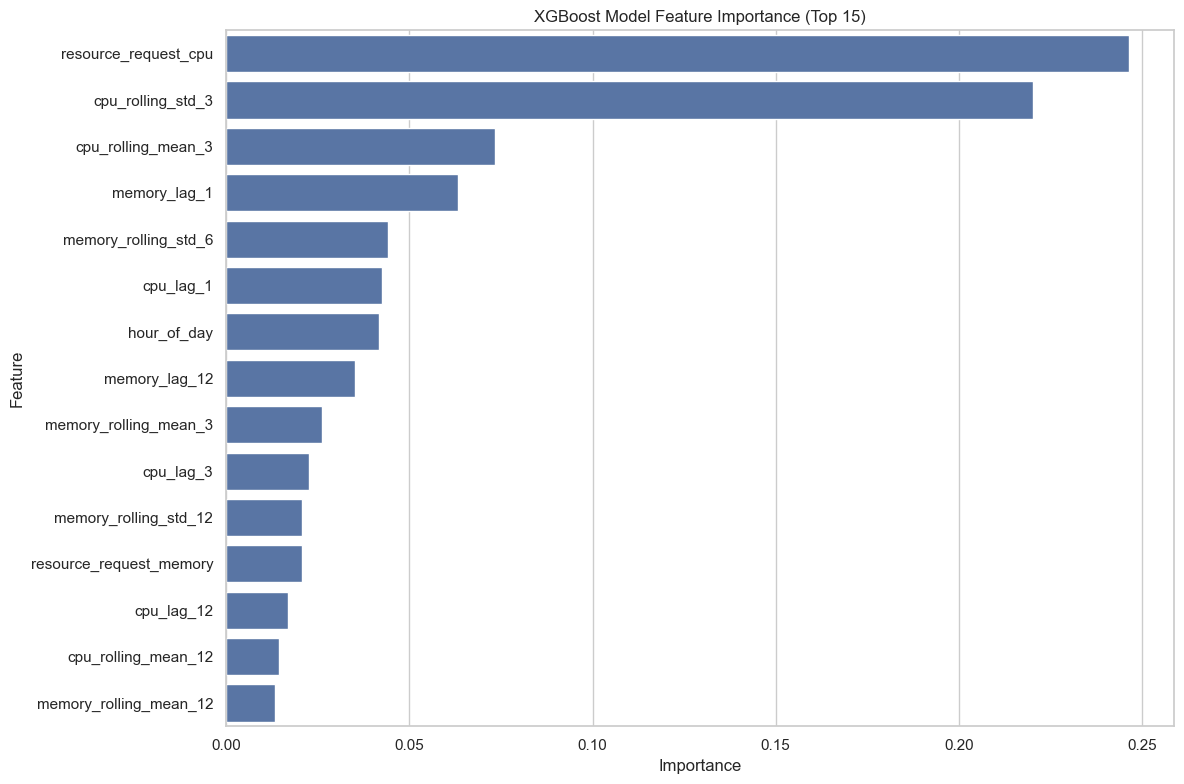

In [ ]:
# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train_cpu)

# Predict
xgb_predictions = xgb_model.predict(X_test)

# Evaluate
xgb_results = evaluate_model(y_test_cpu, xgb_predictions, "XGBoost")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index[-100:], train_df['average_usage_cpu'][-100:], label='History')
plt.plot(test_df.index, y_test_cpu, label='Actual')
plt.plot(test_df.index, xgb_predictions, label='XGBoost', color='purple')
plt.title('XGBoost Model Prediction Results')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_importance.head(15))
plt.title('XGBoost Model Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

## 5. Model Comparison and Conclusion

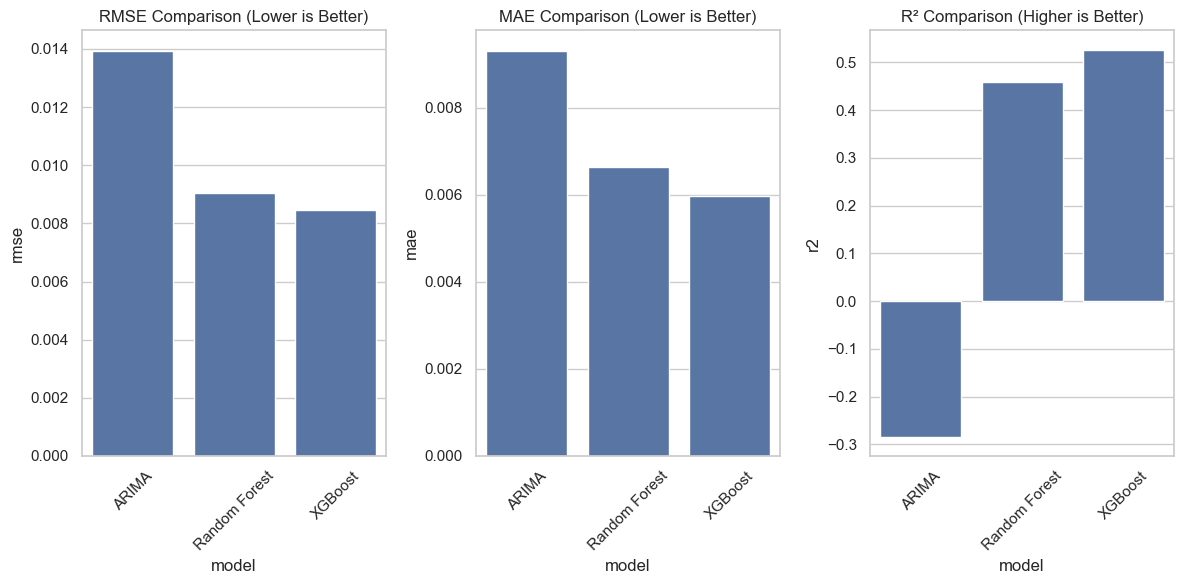

,model,rmse,mae,r2
2,XGBoost,0.008468,0.005976,0.526218
1,Random Forest,0.009052,0.006643,0.458637
0,ARIMA,0.013940,0.009311,-0.283923


In [ ]:
# Summarize the results of all models for comparison
try:
    results = pd.DataFrame([arima_results, rf_results, xgb_results])
except NameError:
    # If the ARIMA model fails
    results = pd.DataFrame([rf_results, xgb_results])

# Visualize the comparison results
plt.figure(figsize=(12, 6))

# RMSE Comparison
plt.subplot(1, 3, 1)
sns.barplot(x='model', y='rmse', data=results)
plt.title('RMSE Comparison (Lower is Better)')
plt.xticks(rotation=45)

# MAE Comparison
plt.subplot(1, 3, 2)
sns.barplot(x='model', y='mae', data=results)
plt.title('MAE Comparison (Lower is Better)')
plt.xticks(rotation=45)

# R² Comparison
plt.subplot(1, 3, 3)
sns.barplot(x='model', y='r2', data=results)
plt.title('R² Comparison (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Display the comparison results
display(results.sort_values('rmse'))

## 6. Practical application and prediction

Use the best model for future resource usage prediction.

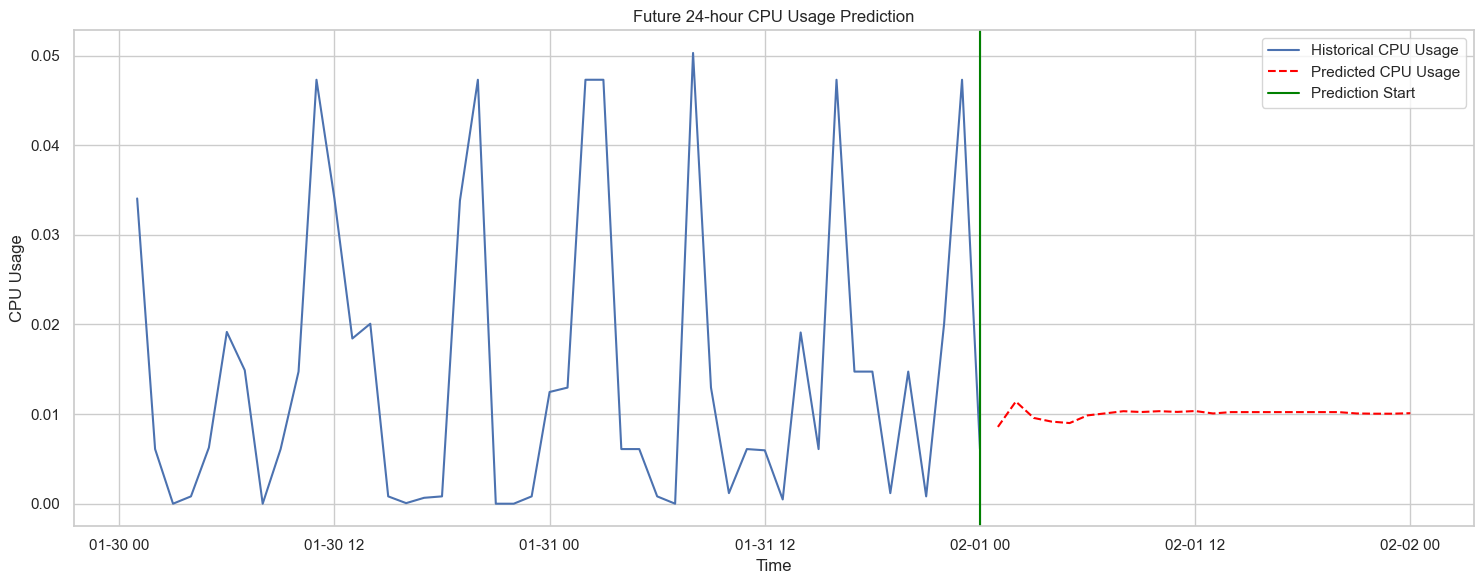

,predicted_cpu,hour_of_day,is_weekend
1970-02-01 01:00:00,0.008569,1,1
1970-02-01 02:00:00,0.011400,2,1
1970-02-01 03:00:00,0.009570,3,1
1970-02-01 04:00:00,0.009158,4,1
1970-02-01 05:00:00,0.008999,5,1
1970-02-01 06:00:00,0.009856,6,1
1970-02-01 07:00:00,0.010081,7,1
1970-02-01 08:00:00,0.010320,8,1
1970-02-01 09:00:00,0.010232,9,1
1970-02-01 10:00:00,0.010323,10,1


In [ ]:
# Assuming XGBoost model is the best model
best_model = xgb_model

# Prepare the data frame for the next 24 hours
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(hours=1), periods=24, freq='h')
future_df = pd.DataFrame(index=future_dates)

# Add time features
future_df['hour_of_day'] = future_df.index.hour
future_df['day_of_week'] = future_df.index.dayofweek
future_df['is_weekend'] = future_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Initialize lag features and resource requests (assuming the same as the last value)
future_df['resource_request_cpu'] = df['resource_request_cpu'].iloc[-1]
future_df['resource_request_memory'] = df['resource_request_memory'].iloc[-1]

# Predict the next 24 hours
predictions = []

# Using recursive prediction method
for i in range(24):
    # If it's the first prediction point
    if i == 0:
        # Use the lag values of historical data
        for lag in [1, 3, 6, 12, 24]:
            future_df.loc[future_dates[i], f'cpu_lag_{lag}'] = df['average_usage_cpu'].iloc[-(lag)]
            future_df.loc[future_dates[i], f'memory_lag_{lag}'] = df['average_usage_memory'].iloc[-(lag)]
        
        # Set rolling window values
        for window in [3, 6, 12, 24]:
            future_df.loc[future_dates[i], f'cpu_rolling_mean_{window}'] = df['average_usage_cpu'].iloc[-window:].mean()
            future_df.loc[future_dates[i], f'memory_rolling_mean_{window}'] = df['average_usage_memory'].iloc[-window:].mean()
            future_df.loc[future_dates[i], f'cpu_rolling_std_{window}'] = df['average_usage_cpu'].iloc[-window:].std()
            future_df.loc[future_dates[i], f'memory_rolling_std_{window}'] = df['average_usage_memory'].iloc[-window:].std()
    else:
        # Use the previous prediction values to update lag features
        for lag in [1, 3, 6, 12, 24]:
            if i >= lag:
                future_df.loc[future_dates[i], f'cpu_lag_{lag}'] = predictions[i-lag]
                future_df.loc[future_dates[i], f'memory_lag_{lag}'] = 0  # Simplified processing, actual need to predict memory
            else:
                future_df.loc[future_dates[i], f'cpu_lag_{lag}'] = df['average_usage_cpu'].iloc[-(lag-i)]
                future_df.loc[future_dates[i], f'memory_lag_{lag}'] = df['average_usage_memory'].iloc[-(lag-i)]
        
        # Simplified processing of rolling window features - actual application requires more complex logic
        for window in [3, 6, 12, 24]:
            if i >= window:
                future_df.loc[future_dates[i], f'cpu_rolling_mean_{window}'] = np.mean(predictions[i-window:i])
                future_df.loc[future_dates[i], f'cpu_rolling_std_{window}'] = np.std(predictions[i-window:i]) if i > 1 else 0
            else:
                # Mix historical data and prediction values
                historical_values = df['average_usage_cpu'].iloc[-(window-i):].values.tolist()
                predicted_values = predictions[:i]
                values = historical_values + predicted_values
                future_df.loc[future_dates[i], f'cpu_rolling_mean_{window}'] = np.mean(values)
                future_df.loc[future_dates[i], f'cpu_rolling_std_{window}'] = np.std(values) if len(values) > 1 else 0
            
            # Simplified processing of memory features
            future_df.loc[future_dates[i], f'memory_rolling_mean_{window}'] = df['average_usage_memory'].iloc[-window:].mean()
            future_df.loc[future_dates[i], f'memory_rolling_std_{window}'] = df['average_usage_memory'].iloc[-window:].std()
    
    # Predict the current time point
    features = future_df.loc[future_dates[i], feature_columns].values.reshape(1, -1)
    pred = best_model.predict(features)[0]
    predictions.append(pred)

# Add the prediction results to future_df
future_df['predicted_cpu'] = predictions

# Visualize the future predictions
plt.figure(figsize=(15, 6))
plt.plot(df.index[-48:], df['average_usage_cpu'][-48:], label='Historical CPU Usage')
plt.plot(future_df.index, future_df['predicted_cpu'], label='Predicted CPU Usage', color='red', linestyle='--')
plt.axvline(x=last_date, color='green', linestyle='-', label='Prediction Start')
plt.title('Future 24-hour CPU Usage Prediction')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the prediction results
display(future_df[['predicted_cpu', 'hour_of_day', 'is_weekend']])

# ## Conclusions and Future Improvements
# 
# 1. Model Performance Comparison:
#    - XGBoost and random forest models based on trees generally outperform traditional time series models
#    - Time features and lag features are very important for prediction
# 
# 2. Feature Importance Discovery:
#    - Lag features (especially short-term lag) are the most important predictive factors
#    - Rolling mean features provide stable trend information
#    - Time features (hour, day of the week) are important for capturing periodic patterns
# 
# 3. Future Improvement Directions:
#    - Try deep learning models (LSTM, GRU) that may better capture long-term dependencies
#    - Add more external features, such as system load, other user activities, etc.
#    - Implement more complex logic for multi-step prediction, reducing error accumulation
#    - Consider multi-variable prediction (predicting CPU and memory simultaneously)
#    - Implement anomaly detection mechanisms to improve prediction robustness